## Проект: "E-commerce — Анализ товарного ассортимента"

### Задача: 
Провести анализ товарного ассортимента интернет-магазина товаров для дома и быта «Пока все ещё тут». Дать рекомендации по корректировке ассортимента для увеличения прибыли.

### Описание данных:
Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут»

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Предобработка данных
- Импортируем библиотеки
- Откроем датасет
- Изучим инфо
- Проверим на наличие пропусков и дубликатов
- Приведем данные к верным форматам

In [1]:
#Импортируем библиотеки
import pandas as pd
import math as mth
from scipy import stats as st
import random
import numpy as np

#визуализация
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import seaborn as sns; sns.set()
import plotly
plotly.io.renderers.default = 'colab'

In [2]:
#Открываем датафрейм
df = pd.read_csv('https://code.s3.yandex.net/datasets/ecommerce_dataset.csv')

In [3]:
#Смотрим датафрейм
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [4]:
#Смотрим инфо
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [5]:
#Смотрим пропуски
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

In [6]:
#Смотрим дубликаты
df.duplicated().sum()

0

In [7]:
#Меняем тип данных
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

df['month'] = df['date'].astype('datetime64[M]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6737 non-null   datetime64[ns]
 1   customer_id  6737 non-null   object        
 2   order_id     6737 non-null   int64         
 3   product      6737 non-null   object        
 4   quantity     6737 non-null   int64         
 5   price        6737 non-null   float64       
 6   month        6737 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 368.6+ KB


### Исследовательский анализ данных
- Посмотрим за какой период есть данные
- Посчитаем количество продаж
- Посчитаем количество уникальных клиентов
- Визуализируем данные по времени
- Проверим на выбросы

In [8]:
#Посмотрим период
df['date'].sort_values().unique()

array(['2018-10-01T00:00:00.000000000', '2018-10-01T08:00:00.000000000',
       '2018-10-01T09:00:00.000000000', ...,
       '2019-10-31T13:00:00.000000000', '2019-10-31T14:00:00.000000000',
       '2019-10-31T16:00:00.000000000'], dtype='datetime64[ns]')

Имеем данные с 1.10.2018 по 31.10.2019. Год и один месяц

In [9]:
#Количество уникальных покупателей
len(df['customer_id'].unique())

2451

2451 разных покупателей совершили хотя бы одну покупку за данный период

In [10]:
#Изучим кол-во товара в заказе
df['quantity'].describe()

count    6737.000000
mean        2.501559
std        15.266478
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

Первый, второй и третий квартили равны 1. Медиана и стандартное отклонение сильно рознятся из-за выбросов. В основном люди делают заказ на один товар. Взглянем как распроделяются заказы по числу товаров.

In [11]:
# Запишем функцию для графика распределения
def dfplot(df, column, x):
  
    fig, ax = plt.subplots(figsize=(14,5))
    plt.xlabel(x)
    plt.ylabel('Плотность распределения')
    plt.title('Распределение по количеству')
    
    sns.kdeplot(df[column], shade=True)
    
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    plt.show()

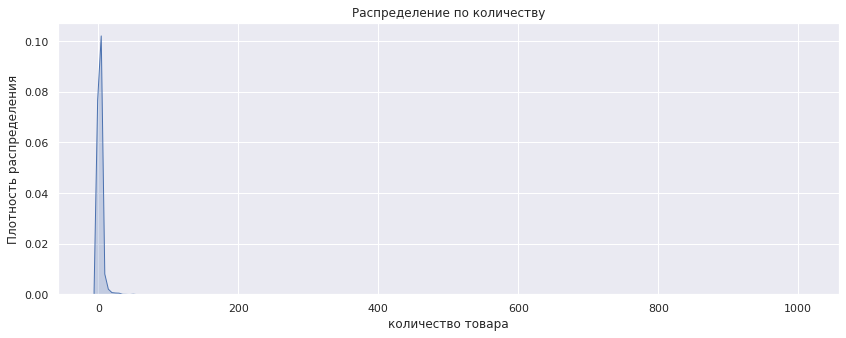

In [12]:
dfplot(df, 'quantity', 'количество товара')

Основная масса заказывают по одному товару. Отсечем до 10 штук в заказе.

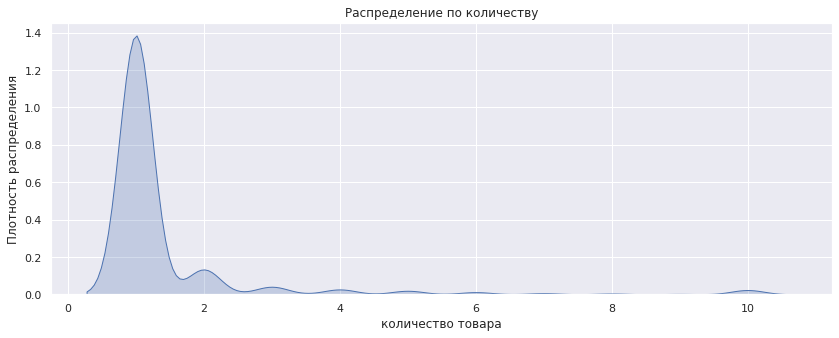

In [13]:
df_b = df.query('quantity <= 10')
dfplot(df_b, 'quantity', 'количество товара')

Всё равно основная масса это 1-2 товара в заказе.

In [14]:
#Глянем какие товары есть в выбросах:
df.query('quantity > 200')['product'].unique()

array(['Муляж ЯБЛОКО 9 см красное',
       'Вешалки мягкие для деликатных вещей 3 шт шоколад',
       'Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000'],
      dtype=object)

In [15]:
df.query('quantity > 100 and quantity < 200')['product'].unique()

array(['Крепеж для пружины дверной, 1107055',
       'Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014',
       'Муляж ЯБЛОКО 9 см красное',
       'Плечики пластмассовые Размер 52 - 54 Тула 1205158'], dtype=object)

In [16]:
df.query('quantity > 50 and quantity < 100')['product'].unique()

array(['Крючок одежный 2-х рожковый серый металлик с полимерным покрытием *Тонар*, 1110027',
       'Стяжка оконная с болтом СТ-55 цинк, 1108354',
       'Набор ножей Attribute CHEF 5 предметов AKF522',
       'Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ',
       'Ковш пластмассовый Полимербыт С215, 1,5 л 1406006',
       'Салфетка Protec Textil Polyline 30х43 см Аметист белая 6230',
       'Насадка на валик ВММ-200/60 белый искусственный мех, 0703011',
       'Универсальный нож WEBBER из нержавеющей стали Русские мотивы 12,7 см с деревянной ручкой ВЕ-2252D',
       'Кружка с трубочкой Attribute МЯЧ 500 мл JAR501',
       'Искусственный цветок Подснежник садовый пластиковый белый'],
      dtype=object)

In [17]:
df.query('quantity > 10 and quantity < 50')['product'].unique()

array(['Щетка-сметка 3-х рядная деревянная 450 мм (плоская ручка), Поиск Риф 1801095',
       'Щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096',
       'Герань домашняя (пеларгония зональная) цветущая D12, H25-30, коралловая, полумахровая',
       'Ёрш унитазный с деревянной ручкой , Ваир 1712012',
       'Набор вешалок для костюма 45см 4шт цвет: кремовый, Attribute, AHP224',
       'Крючок одежный тройной латунь (Б-47), 1110182',
       'Муляж Апельсин 8 см полиуретан',
       'Муляж Яблоко зеленый 9 см полиуретан',
       'Муляж Красное яблоко мини полиуретан d-6 см',
       'Веник сорго с деревянной ручкой с 4-мя швами, Rozenbal, R206204',
       'Тарелка обеденная Luminarc ГРИН ФОРЕСТ 26 см H7239',
       'Сервировочная салфетка ПВХ 26х41 см Ванда 6001',
       'Набор вешалок мягких тканевых с перекладиной и клипсами 48х23 см 2 шт Валиант / Valiant VAL 7057gc',
       'Коврик придверный Attribute NATURE кокосовый 60x40 см AMC015',
       'Цветок искус

По ассортименту видно, что крупные заказы в большинстве своем делают на мелкие товары: Расходники, фурнитуру и т.д.

Так же возможны групповые заказы и заказы для ИП и ООО

Оставляем весь df. Явных выбросов и ошибок в данных нет.

In [18]:
# Посмотрим на выручку
df['price'].describe()

count     6737.000000
mean       462.028499
std        871.296064
min          9.000000
25%        101.000000
50%        135.000000
75%        398.000000
max      14917.000000
Name: price, dtype: float64

Разброс довольно большой, но это очевидно. среднее значение цены с одного заказа 462 рубля (пусть будут рубли)

In [19]:
df_b['price'].describe()

count     6559.000000
mean       471.514713
std        880.592731
min          9.000000
25%        106.000000
50%        135.000000
75%        415.500000
max      14917.000000
Name: price, dtype: float64

по заказам до 10 штук та же картина. Всё логично.

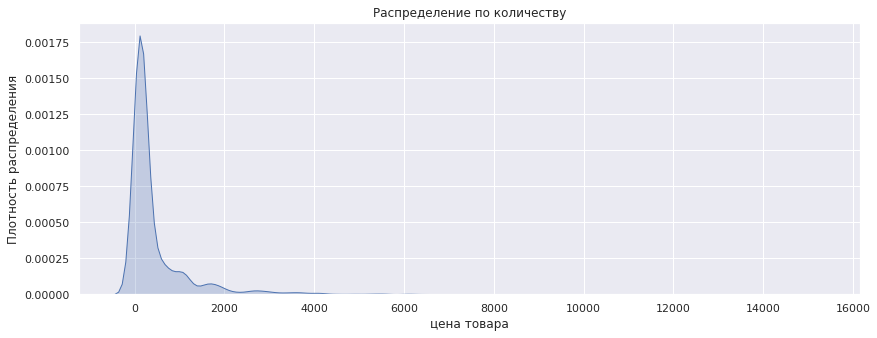

In [20]:
dfplot(df_b, 'price', 'цена товара')

In [21]:
df.query('price > 8000')['product'].unique()

array(['Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90',
       'Сумка-тележка хозяйственная Andersen Royal Shopper, Hera, синяя 166-004-90',
       'Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная',
       'Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая'],
      dtype=object)

Опять же ничего удивительного. Дорогие товары берут реже дешевых.

In [22]:
df['total'] = df['price'] * df['quantity']
df['total'].describe()

count      6737.000000
mean        720.094998
std        8352.100591
min           9.000000
25%         120.000000
50%         162.000000
75%         600.000000
max      675000.000000
Name: total, dtype: float64

Добавили столбец с выручкой по каждому заказу. Средняя выручка 720 рублей

In [23]:
fig = go.Figure(data=go.Scatter(x=df['date'], 
                                y=df['total'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': "Динамика выручки за весь период",
        'xanchor': 'center',
        'x':0.5
    },
    yaxis_title="Выручка",
    xaxis_title="Дата")
fig.show()

Если рассматривать все товары, то сезонность не наблюдается. Есть выброс летом, но это не показатель

### Проанализируем торговый ассортимент
- Разобьем проданные товары на категории
- Выясним какие категории товаров приносят наибольший доход
- Проверим товары на сезонность

In [24]:
dacha = ['растение','пеларгония','помидор', 'герань','петуния','горшке','бакопа',
          'кассете','калибрахоа', 'базилик', 'петрушка', 'томат', 'кашпо',
          'лобелия', 'фуксия', 'вербена', 'цветк', 'смесь', "микс", 'земляника', 
          'клубника', 'ель', 'упаков', 'укроп', 'd-', 'камнеломка', 'примула',
          'вербейник', 'колокольчик', 'цикламен', 'барвинок', 'дыня', 'овсянница',
          'папоротник', 'кипарис', 'бегония', 'осина', 'арбуз',' г ','рассада','муляж', 'искусственн'
          'черенок''корыт', 'таз', 'контейнер', 'бак ', 'мусор', 'ведр', 'урна', 'корзин',
          'бидон', 'ковш','коробка', 'емкость']

dom = ['покрытие', 'перчат', 'почтов','чехол','ковр', 'ткан', 'штор', 'ковер',
       'термометр', 'ковёр', 'светил', 'весы','одеял', 'простын', 'подуш', 'плед',
       'матрас', 'мыло', 'покрывало', 'спальн','наволочка','тряп', 'швабр', 'совок', 'гладил', 'глажен', 'прищеп',
       'налет', 'антижир', 'пылесос', 'крем', 'стир', 'щетка', 'сушилк', 'веник', 
       'подрукавник', 'совком', 'для чистки', 'стирки', 'мыть', 'средство','мойк','ванн', 'полотен', 'ёрш',
       'ерш', 'зуб', 'вантуз', 'халат',]

stroy = ['полки', 'вешал', 'плечики', 'стеллаж', 'хранен', 'крючок', "этажерка", 'комод', 
         'подставка', 'полка', 'кофр', 'лоток','инструмент', 'сверел', 'сверло', 'напильник',
         'стремянк', 'стяжк', 'шпингалет', 'сварка', 'миксер', 'крепеж', 'пружин', 'петл',
         'линейк', 'гои','корыт', 'таз', 'контейнер', 'бак ', 'мусор', 'ведр', 'урна', 'корзин',
         'бидон', 'ковш', 'коробка', 'емкость','сумка', 'тележ']

In [25]:
#функция присвоения категории
df['category'] = 0
def categor(words, category):
  join = '|'.join(words)
  index = df[df['product'].str.lower().str.contains(join)].index.to_list()
  for i in index:
    df.loc[i, 'category'] = category
  return df

In [26]:
# присвоим категории товарам в нашем датафрейме
categor(dacha, 'Огород')
categor(dom, 'Дом')
categor(stroy, 'Ремонт')
df['category'] = df['category'].apply(lambda x: 'Разное' if (x==0) else x)

In [27]:
categor_df = df.groupby('category').agg({'product':'count'}).reset_index()
categor_df

,category,product
0,Дом,1126
1,Огород,4110
2,Разное,541
3,Ремонт,960


Получили 4 категории. Категория огород самая крупная.

In [28]:
grouped_category = df.groupby('category').agg({'customer_id':'nunique', 'price':'mean', 'total':'sum'})
grouped_category.columns = ['buyers', 'avg_price', 'gain']
grouped_category['gain_buyers'] = grouped_category['gain'] / grouped_category['buyers']
grouped_category = grouped_category.sort_values(by='gain_buyers', ascending = False)
grouped_category['percent_gain'] = grouped_category['gain'] / grouped_category['gain'].sum()
grouped_category['percent_gain'] = grouped_category['percent_gain'].map('{:.2%}'.format)
grouped_category['percent_buyers'] = grouped_category['buyers'] / grouped_category['buyers'].sum()
grouped_category['percent_buyers'] = grouped_category['percent_buyers'].map('{:.2%}'.format)

grouped_product = df.groupby('product').agg({'customer_id':'nunique', 'quantity':'mean', 'price':'mean', 
                                                'category':'first', 'total':'sum'}).reset_index().sort_values(by='customer_id', ascending=False)
grouped_product.columns = ['product', 'buyers', 'avg_quantity', 'price', 'category', 'total_gain']

display(grouped_category)
display(grouped_product)
display('Кол-во товаров, которые приобрели 5 и более покупателей: {}\n'.format(len(grouped_product[grouped_product['buyers']>=5])))
for category in grouped_product['category'].unique():
  display('ТОП-5 {}:'.format(category))
  display(grouped_product[grouped_product['category']==category].head(5))
  display('')

,buyers,avg_price,gain,gain_buyers,percent_gain,percent_buyers
category,,,,,,
Дом,769,950.460924,2023481.0,2631.314694,41.71%,30.20%
Ремонт,631,1342.817708,1615911.0,2560.873217,33.31%,24.78%
Огород,781,142.110706,852966.0,1092.145967,17.58%,30.68%
Разное,365,312.914972,358922.0,983.347945,7.40%,14.34%


,product,buyers,avg_quantity,price,category,total_gain
1042,Пеларгония розебудная Red Pandora укорененный ...,63,1.236842,134.842105,Огород,12670.0
1040,Пеларгония розебудная Prins Nikolai укорененны...,54,1.106061,134.772727,Огород,9839.0
1017,Пеларгония зональная диам. 12 см сиреневый пол...,47,1.224138,171.620690,Огород,12284.0
1619,Сумка-тележка 2-х колесная Gimi Argo синяя,43,1.000000,1070.180328,Ремонт,65281.0
1039,Пеларгония розебудная Mary укорененный черенок,35,1.195122,134.829268,Огород,6606.0
...,...,...,...,...,...,...
867,Набор вешалок универсальных Attribute NEO BLUE...,1,4.000000,374.000000,Ремонт,1496.0
866,Набор вешалок пластмассовых Rozenbal R181900,1,1.000000,157.000000,Ремонт,157.0
865,Набор вешалок мягких тканевых с перекладиной и...,1,15.000000,398.000000,Ремонт,5970.0
864,Набор вешалок мягких тканевых с перекладиной 3...,1,2.000000,277.000000,Ремонт,554.0


'Кол-во товаров, которые приобрели 5 и более покупателей: 169\n'

'ТОП-5 Огород:'

,product,buyers,avg_quantity,price,category,total_gain
1042,Пеларгония розебудная Red Pandora укорененный ...,63,1.236842,134.842105,Огород,12670.0
1040,Пеларгония розебудная Prins Nikolai укорененны...,54,1.106061,134.772727,Огород,9839.0
1017,Пеларгония зональная диам. 12 см сиреневый пол...,47,1.224138,171.620690,Огород,12284.0
1039,Пеларгония розебудная Mary укорененный черенок,35,1.195122,134.829268,Огород,6606.0
1038,Пеларгония розебудная Margaretha укорененный ч...,29,1.714286,135.200000,Огород,8103.0


''

'ТОП-5 Ремонт:'

,product,buyers,avg_quantity,price,category,total_gain
1619,Сумка-тележка 2-х колесная Gimi Argo синяя,43,1.0000,1070.180328,Ремонт,65281.0
1896,Тележка багажная DELTA ТБР-20 синий грузоподъе...,16,1.0000,732.812500,Ремонт,11725.0
1895,Тележка багажная DELTA ТБР-20 коричневый с ора...,14,1.0625,710.875000,Ремонт,11749.0
1628,Сумка-тележка 2-х колесная складная Gimi Flexi...,10,1.1000,1649.000000,Ремонт,18139.0
1853,"Таз пластмассовый со стиральной доской (Иж), 1...",10,1.0000,341.428571,Ремонт,4780.0


''

'ТОП-5 Дом:'

,product,buyers,avg_quantity,price,category,total_gain
1777,Сушилка для белья настенная Zalger Prima 510-7...,16,1.166667,274.166667,Дом,5832.0
1804,"Сушилка для белья потолочная Лиана 2,0 м 1703009",10,1.000000,599.000000,Дом,7188.0
1773,Сушилка для белья напольная НИКА СБП1/С 18 м,9,1.111111,599.000000,Дом,5990.0
1806,"Сушилка для белья потолочная Лиана 2,4 м 1703011",9,1.000000,734.000000,Дом,7340.0
1500,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",7,1.111111,335.777778,Дом,3224.0


''

'ТОП-5 Разное:'

,product,buyers,avg_quantity,price,category,total_gain
2025,Цветок искусственный Гвоздика пластиковая один...,7,13.714286,21.142857,Разное,2007.0
689,"Кувшин пластмассовый с крышкой ""Кумган"" 2,0 л ...",5,1.000000,149.000000,Разное,745.0
2029,Цветок искусственный Крокус 20 см,5,5.222222,21.555556,Разное,987.0
387,Искусственная композиция из цветов пластиковая...,5,3.400000,57.000000,Разное,959.0
389,"Искусственная лиана Плющ 2,4 м",4,2.250000,82.000000,Разное,1476.0


''

Больше всего прибыли приносит категория ДОМ за счет высокой стоимости товаров. Товары из Раздела Огород продаются больше всего, но за счет низкой стоимости выручка с них небольшая.

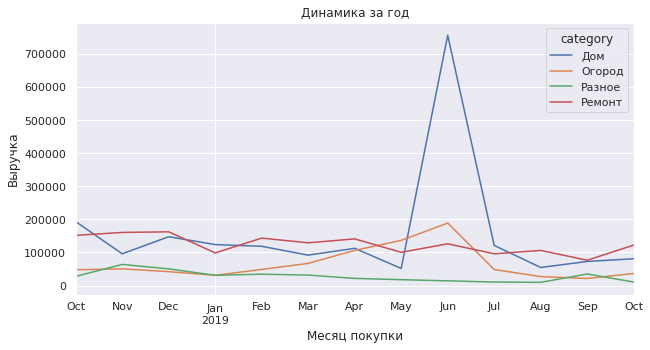

In [29]:
df.pivot_table(
    index='month', columns='category', values='total', aggfunc='sum'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Выручка')
plt.xlabel('Месяц покупки')
plt.title('Динамика за год')
plt.show()

По категориям Ремонт и Разное сезонности не наблюдается. В категории Огород начинается плавный рост прибыли с февраля с пиком в июле - сезон садовых работ. В категории дом наблюдается резкий скачек в июне. Это связано в аномально большой покупкой. Сезонности в этой категории так же нет.

### Сформулируем и проверим статистические гипотезы

Категория Дом приносит больше прибыли, а Категория Огород больше заказов. 

H0 - Средний чек в категории Дом равен среднему чеку в категории Огород.

H1 - Средний чек в категории Дом не равен среднему чеку в категории Огород.

In [30]:
df_dom= df.query('category == "Дом"')['total']
df_dacha= df.query('category == "Огород"')['total']

alpha = .05

results = st.ttest_ind(
    df_dom, 
    df_dacha, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.008320736399420606
Отвергаем нулевую гипотезу


Средние чеки не равны за счет сильных различий в цене товара этих категорий.

### Сформируем выводы и рекомендации на основании полученных данных

- Имеются данные за период с 1.10.2018 по 31.10.2019.
- За этот период было проведено 6737 транзакций.
- 2451 разных покупателей совершили хотя бы одну покупку за данный период.
- В подавляющем большинстве заказ состоит из одного товара, а крупные заказы в большинстве своем делают на мелкие товары: Расходники, фурнитуру и т.д.
- Средняя цена товара 462 рубля.
- Средняя выручка 720 рублей с одного заказа.

С помощью лемматизации нами были выделены 4 основные группы товаров:

1. Товары для Сада и Огород;
2. Товары для Дома;
3. Товары для Ремонта;
4. Разное.

- 41.71% выручки приходится на товары из категории Дом.
- Самое большое количество позиций в категории Огород: 4110 штук.
- Больше всего прибыли приносят товары категории ДОМ за счет высокой стоимости товаров. Товары из Раздела Огород продаются больше всего, но за счет низкой стоимости выручка с них небольшая.
- Сезонность показали товары лишь в категории Огород. В период с февраля по июнь наблюдается увеличение прибыли по этой категории более чем на 100%
- Гипотезу о соразмерности среднего чека категорий Дом и Огород поддтвердить не удалось.

### Рекомендации

- Для увеличения количества товаров в одном заказе рекомендуется размещать сопутствующие товары для каждой позиции. Предлагать Наиболее популярные товары из соответствующих категорий при добавлении товара в корзину.
- Увеличить ассортимент категории Огород в начале сезона. Делать скидки на товары этой категории перед началом сезона.
- Провести рекламную компанию для категории Дом, как самую прибыльную, но менее популярную среди покупателей.

### Создадим дашборд

Ссылка на дашборд: https://public.tableau.com/app/profile/tim3879/viz/FinalBoss_16572932884370/Sheet1?publish=yes

### Создадим презентацию

Ссылка на презентацию: https://disk.yandex.ru/i/gyEm-45NHlte6g